# Tests on dinov2 embeddings

## Imports

In [1]:
import os
import torch

## Checking torch cache dir
Warning : make sure to set torch hub cache dir to reuse downloade

In [2]:
torch.hub.get_dir()

'/linkhome/idris/genidr/ssos023/.cache/torch/hub'

## Setting torch cache dir for download

In [3]:
import os
import torch

def set_torch_hub_dir(custom_path=None):
    """
    Set the directory for storing models downloaded via torch.hub.

    Parameters:
    - custom_path (str, optional): A custom path to set as the torch.hub directory.
                                   If not provided, the function will attempt to use
                                   the path specified by the 'ALL_CCFRWORK' environment variable.
    
    Returns:
    - str or None: The path to the torch.hub directory if set successfully, None otherwise.
    
    This function sets the directory where torch.hub should look for or save models.
    If a custom path is provided, it uses that path; otherwise, it looks for the
    'ALL_CCFRWORK' environment variable to determine the path. If neither is available,
    it prints an error message and returns None.
    """
    # Define the environment variable key
    env_var = 'ALL_CCFRWORK'

    # Determine the base path using either the provided custom path or environment variable
    base_path = custom_path if custom_path else os.getenv(env_var)
    
    if base_path:
        # Join the base path with 'models' subdirectory
        hub_dir = os.path.join(base_path, 'models')
        # Set the torch.hub directory to the determined path
        torch.hub.set_dir(hub_dir)
        # Notify the user of the set directory
        print(f"Model directory set to: {hub_dir}")
        return hub_dir
    else:
        # Build an appropriate error message based on the input provided
        error_message = "Custom path is invalid." if custom_path else f"Environment variable '{env_var}' is not set."
        # Print the error message
        print(error_message)
        return None

# Example of usage
# You can pass a custom path directly or just call without parameters to use the environment variable# 
hub_dir = set_torch_hub_dir()
torch.hub.get_dir()

Model directory set to: /gpfswork/rech/ads/commun/models


'/gpfswork/rech/ads/commun/models'

## Download dinov2 weights

In [4]:
import torch
import gc  # Garbage collector interface
from tqdm import tqdm  # Import tqdm for progress bar functionality

def download_and_clear_memory(model_name):
    """
    Downloads a specified DINOv2 model and immediately clears it from memory.

    This function is designed to populate the cache with DINOv2 models without retaining
    them in RAM, which is useful for pre-caching models on systems where memory is limited.

    Parameters:
    - model_name (str): The name of the DINOv2 model to download. This name must match
                        the model identifier used by `torch.hub.load`.

    Returns:
    - None
    """
    # Download the model
    model = torch.hub.load('facebookresearch/dinov2', model_name)
    # Immediately release the model from memory
    del model
    #torch.cuda.empty_cache()  # Clear CUDA cache if GPUs are used
    gc.collect()  # Run garbage collection to free up memory

# List of model names to be downloaded
model_names = [
    'dinov2_vits14_reg',
    'dinov2_vitb14_reg',
    'dinov2_vitl14_reg',
    # 'dinov2_vitg14_reg'  # Uncomment or add more model names as needed
]


## Loading a dinov2

In [5]:
import os
import warnings

# Verify that it was set
print(os.environ.get("XFORMERS_DISABLED"))

# Set the environment variable if we want to disable xformers
#os.environ["XFORMERS_DISABLED"] = "False"

XFORMERS_ENABLED = os.environ.get("XFORMERS_DISABLED") is None
try:
    if XFORMERS_ENABLED:
        from xformers.ops import memory_efficient_attention, unbind

        XFORMERS_AVAILABLE = True
        warnings.warn("xFormers is available (Attention)")
    else:
        warnings.warn("xFormers is disabled (Attention)")
        raise ImportError
except ImportError:
    XFORMERS_AVAILABLE = False
    warnings.warn("xFormers is not available (Attention)")


None


/tmp/ipykernel_2329342/2412708894.py:16: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")


In [6]:
XFORMERS_ENABLED

True

In [7]:
import torch

model_name = 'dinov2_vits14_reg'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.hub.load('facebookresearch/dinov2', model_name).to(device)


Using cache found in /gpfswork/rech/ads/commun/models/facebookresearch_dinov2_main
/gpfswork/rech/ads/commun/models/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/gpfswork/rech/ads/commun/models/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/gpfswork/rech/ads/commun/models/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


### Copying last attention layer
Keeping a copy that will be unchange of the layer we will change to not reload

In [8]:
import copy

# Assuming the last attention layer is what you want to clone
original_attn_layer = model.blocks[-1].attn

# Create a deep copy of the attention layer
cloned_attn_layer = copy.deepcopy(original_attn_layer)

### Model and last layer definition (methods and attributes) check

In [17]:
import inspect
print(model)
# List all attributes and methods of the model
print(dir(model))
# Check if the model has an attribute or method directly exposing the attention maps

# Check if the model has a built-in way to return attention maps
if hasattr(model, 'get_last_selfattention'):
    print("Model supports getting the last self-attention directly.")
else:
    print("Model does not support getting the last self-attention directly. We might need to modify the model.")

print(hasattr(model, 'get_attention_map'))

# Print the current attention layer's setup to understand its configuration
print(model.blocks[-1].attn)
# Print the source code of the MemEffAttention class
print(inspect.signature(model.blocks[-1].attn.__class__.__init__))
print(inspect.getsource(model.blocks[-1].attn.__class__))


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-10): 11 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (11)

OSError: source code not available

In [18]:
print(inspect.signature(model.blocks[-1].attn.__class__.__init__))


(self, dim, num_heads=8, qkv_bias=False, proj_bias=True, attn_drop=0.0, proj_drop=0.0)


### Inspecting output of last attention layer

In [19]:
# Define a function that will be our hook for inspecting outputs
def inspect_attention_hook(module, input, output):
    # Print output to see its structure and dimensions
    print("Output of attention layer:", output)
    print("Shape of output:", output.shape if torch.is_tensor(output) else [o.shape for o in output])

# Attach the hook to the last block's attention layer
last_block = model.blocks[-1].attn
hook = last_block.register_forward_hook(inspect_attention_hook)

# Prepare a dummy input and run a forward pass
dummy_input = torch.randn(1, 3, 224, 224).to(device)
try:
    _ = model(dummy_input)
finally:
    # Remove the hook immediately after use to clean up
    hook.remove()


Output of attention layer: tensor([[[ 0.2825, -0.0481, -0.3678,  ...,  0.2159,  0.1073,  0.2017],
         [ 0.2985, -0.0451, -0.3762,  ...,  0.2226,  0.0796,  0.2043],
         [ 0.3373, -0.0455, -0.3890,  ...,  0.1907,  0.0515,  0.2138],
         ...,
         [ 0.3166, -0.0834, -0.3886,  ...,  0.2177,  0.1299,  0.1914],
         [ 0.3139, -0.0489, -0.3742,  ...,  0.2066,  0.0727,  0.1997],
         [ 0.2976, -0.0548, -0.4001,  ...,  0.2132,  0.1026,  0.2099]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
Shape of output: torch.Size([1, 261, 384])


### Modifying the MemEffAttention

In [20]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

# Retrieve the class of the current attention layer for accurate subclassing
actual_attention_class = cloned_attn_layer.__class__
class CustomMemEffAttention(actual_attention_class):
    def __init__(self, dim, num_heads=8, qkv_bias=False, proj_bias=True, attn_drop=0.0, proj_drop=0.0):
        super(CustomMemEffAttention, self).__init__(
            dim=dim, 
            num_heads=num_heads, 
            qkv_bias=qkv_bias, 
            proj_bias=proj_bias, 
            attn_drop=attn_drop, 
            proj_drop=proj_drop
        )
        self.last_attention_map = None  # Attribute to store the last attention map
    
    def forward(self, x: Tensor, attn_bias=None, return_attn=False) -> Tensor:
        if not XFORMERS_AVAILABLE:
            if attn_bias is not None:
                raise AssertionError("xFormers is required for using nested tensors")
            return super().forward(x)

        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = torch.unbind(qkv, dim=2)

        x = memory_efficient_attention(q, k, v, attn_bias=attn_bias)
        attn = x.permute(0, 2, 1, 3) @ v.permute(0, 2, 3, 1)  # Calculate the attention map

        x = x.reshape([B, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)

        self.last_attention_map = attn.detach()
        if return_attn:
            return x, attn.detach()
        return x


In [21]:
# Extracting parameters from the cloned attention layer
num_heads = cloned_attn_layer.num_heads  # Number of attention heads
dim = cloned_attn_layer.qkv.out_features // 3  # Dimension should be checked against how qkv is set up in the class

# Bias in qkv and projection can be inferred from the existence and not None check
qkv_bias = cloned_attn_layer.qkv.bias is not None
proj_bias = cloned_attn_layer.proj.bias is not None

# Dropout values; these should be checked if they exist and are applied in the cloned layer
attn_drop = cloned_attn_layer.attn_drop.p if hasattr(cloned_attn_layer, 'attn_drop') else 0.0
proj_drop = cloned_attn_layer.proj_drop.p if hasattr(cloned_attn_layer, 'proj_drop') else 0.0

# Replace the existing attention layer in the last block
model.blocks[-1].attn = CustomMemEffAttention(
    dim=dim,
    num_heads=num_heads,
    qkv_bias=qkv_bias,
    proj_bias=proj_bias,
    attn_drop=attn_drop,
    proj_drop=proj_drop
).to(device) # Since we've replaced a module that contains parameters, ensure to move the parameters to the correct device

### Dynamically Override the forward Method of the model


In [22]:
import torch
import torch.nn as nn

def modified_forward(model, return_attn=False):
    original_forward = model.forward

    def forward(*args, **kwargs):
        # Check if return_attn is specified in the call to forward
        return_attn = kwargs.pop('return_attn', False)
        
        # Use the original forward to compute the output
        output = original_forward(*args, **kwargs)
        
        if return_attn:
            # Assume we modify the model to have an attribute `last_attention_map`
            # in its attention layer as previously described
            attn_maps = [block.attn.last_attention_map for block in model.blocks if hasattr(block.attn, 'last_attention_map')]
            return output, attn_maps
        return output

    return forward

# Assuming `model` is an instance of DinoVisionTransformer
model.forward = modified_forward(model)


## Test forward

In [23]:
image_size = 224

random_image = torch.randn(1, 3, image_size, image_size).to(device)

# Assuming you can modify how the model is called to include return_attn
output, _ = model(random_image, return_attn=True)
print("Output shape:", output.shape)
print("Attention Weights Shape:", model.blocks[-1].attn.last_attention_map.shape)


Output shape: torch.Size([1, 384])
Attention Weights Shape: torch.Size([1, 6, 261, 261])


## Visualisation of attention head

In [38]:
from lynx_id.data.dataset import LynxDataset
from pathlib import Path
import cv2
import numpy as np
import albumentations as A
import albumentations.pytorch as AP
import torch

# Load the dataset
dataset_csv = Path('/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full.csv')
dataset = LynxDataset(dataset_csv, mode='single')  # Default mode

# Get the first item from the dataset
input, output = dataset[0]

# Define the transformations using Albumentations
newH, newW = 518, 518
transform = A.Compose([
    A.Resize(newH, newW, interpolation=cv2.INTER_CUBIC),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    AP.ToTensorV2()  # Ensures that the image is transformed to a torch tensor
])

# Apply the transformations to the image
if isinstance(input['image'], np.ndarray):
    input_image = input['image']
else:
    input_image = np.array(input['image'])

# Albumentations requires a dictionary with an image key
transformed = transform(image=input_image)
transformed_image = transformed['image']

# Assuming 'model' is already defined and loaded elsewhere
# Make sure the model is in evaluation mode
model.eval()
with torch.no_grad():
    embeddings, attentions = model(transformed_image.unsqueeze(0).to(device), return_attn=True)  # Add batch dimension

attentions = attentions[0] # Keep only the first block
print(embeddings.shape)
print(attentions.shape)
nh = attentions.shape[1] # number of head

torch.Size([1, 384])
torch.Size([1, 6, 1374, 1374])


In [39]:
attentions = attentions[0, :, 0, 5:].reshape(nh, -1)

attentions.shape

torch.Size([6, 1369])

In [40]:
model_patch_size = 14
transformed_image.shape
threshold = 0.6
w_featmap = transformed_image.shape[-2] // model_patch_size
h_featmap = transformed_image.shape[-1] // model_patch_size
print(w_featmap, h_featmap, nh)

37 37 6


In [41]:
attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=model_patch_size, mode="nearest")[0].cpu().numpy()
print(attentions.shape)


(6, 518, 518)


In [42]:
attention_avg = np.mean(attentions, axis=0)  # Move to CPU and average over heads
print(attention_avg.shape)


(518, 518)


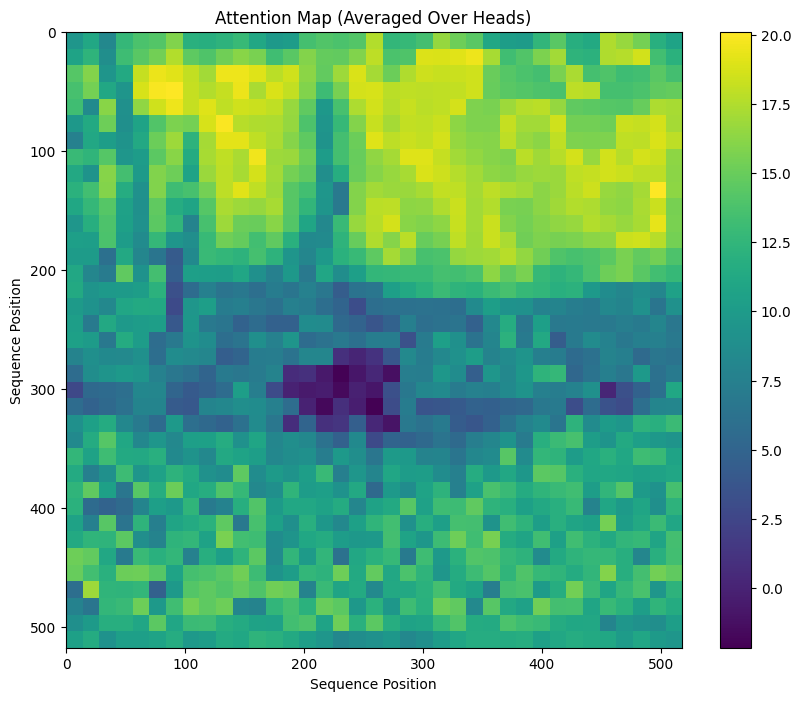

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


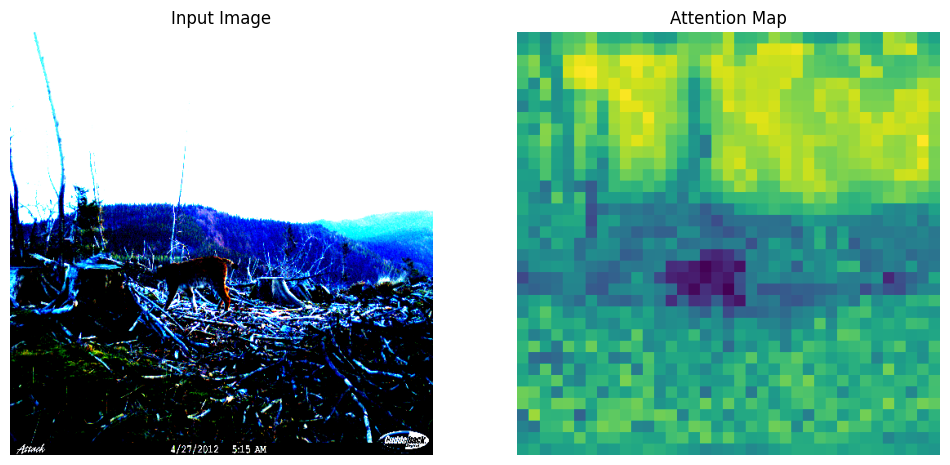

In [43]:
import torch
import matplotlib.pyplot as plt


# Select a subset of the sequence for visualization (if the full size is too large)
#subset_size = 50  # Example: visualize the first 50 tokens
attention_subset = attention_avg#[:subset_size, :subset_size]

# Now visualize using a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(attention_subset, cmap='viridis', interpolation='nearest')  # Convert to numpy array here
plt.colorbar()
plt.title('Attention Map (Averaged Over Heads)')
plt.xlabel('Sequence Position')
plt.ylabel('Sequence Position')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Show image
axs[0].imshow(transformed_image.squeeze().permute(1, 2, 0).cpu().numpy())  # Adjust for image dimensions and type
axs[0].set_title('Input Image')
axs[0].axis('off')  # Turn off axis

# Show attention map
# Assuming the attention map is already resized/matched to the image dimensions
attention_map = attention_avg / attention_avg.max()  # Normalize for better visualization
axs[1].imshow(attention_map, cmap='viridis')
axs[1].set_title('Attention Map')
axs[1].axis('off')  # Turn off axis

plt.show()



## TRASH

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(attention, image_shape, patch_size=14, include_cls_token=True):
    num_patches_side = image_shape // patch_size
    seq_length = int(np.sqrt(attention.shape[-1]))  # Assuming attention shape is [num_heads, seq_length, seq_length]
    num_heads = attention.shape[0]  # Extract number of heads directly from the attention tensor

    fig, axs = plt.subplots(1, num_heads, figsize=(20, 5))
    if num_heads == 1:
        axs = [axs]  # Make axs iterable if there is only one subplot

    for i, ax in enumerate(axs):
        # Adjust attention map based on whether there's a CLS token
        attn_map = attention[i, 1:, 1:] if include_cls_token else attention[i]
        # Reshape and calculate the mean over spatial dimensions
        attn_map = attn_map.reshape(num_patches_side, num_patches_side, num_patches_side, num_patches_side).mean(axis=(1, 3))
        ax.imshow(attn_map, cmap='viridis')
        ax.axis('off')
    plt.show()

# Usage example:
if attention_maps is not None:
    visualize_attention(attention_maps.detach().cpu(), image_shape=224, patch_size=14, include_cls_token=True)


NameError: name 'attention_maps' is not defined

## Execution performance of dinov2

In [ ]:
import os

def get_available_models(base_path='~/.cache/torch/hub/checkpoints/'):
    # Expand the user path
    full_path = os.path.expanduser(base_path)
    
    # List all files in the directory
    try:
        files = os.listdir(full_path)
    except FileNotFoundError:
        print(f"No directory found at {full_path}, please check the path.")
        return []

    # Filter files to identify model checkpoints
    # This assumes model files follow a naming pattern like 'dinov2_vits14_reg.pth'
    model_prefix = "dinov2_"
    available_models = [f for f in files if f.startswith(model_prefix) and f.endswith('.pth')]
    
    # Remove the file extension and get unique model types
    available_model_types = list(set([f.replace('.pth', '') for f in available_models]))
    return available_model_types

# Call the function and print available models
available_dinov2_models = get_available_models(hub_dir)
print("Available DINOv2 models:", available_dinov2_models)


In [ ]:
import torch
import torch.cuda as cuda
import time


# Dictionary to store models
dinov2_available_versions = {
    'dinov2_vits14_reg': 'dinov2_vits14_reg',
    'dinov2_vitb14_reg': 'dinov2_vitb14_reg',
    'dinov2_vitl14_reg': 'dinov2_vitl14_reg',
    'dinov2_vitg14_reg': 'dinov2_vitg14_reg'
}

# Function to load models
def load_model(model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.hub.load('facebookresearch/dinov2', model_name).to(device)
    return model


In [ ]:
# Function to measure inference metrics
def measure_inference_metrics(model, input_tensor):
    model.eval()
    torch.cuda.synchronize()
    start_mem = cuda.memory_allocated()
    start_time = time.time()
    with torch.no_grad():
        output = model(input_tensor)
    torch.cuda.synchronize()
    end_time = time.time()
    end_mem = cuda.memory_allocated()
    peak_mem = cuda.max_memory_allocated()
    cuda.reset_peak_memory_stats()  # Reset for next measurement
    
    inference_time = end_time - start_time
    cuda.empty_cache()
    return inference_time, output.shape, (peak_mem - start_mem) / (1024 ** 2)  # MB

# Function to measure training metrics
def measure_training_metrics(model, input_tensor):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()  # Dummy loss function for example
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    torch.cuda.synchronize()
    start_mem = cuda.memory_allocated()
    start_time = time.time()
    optimizer.zero_grad()
    output = model(input_tensor)
    loss = criterion(output, torch.randint(0, 1000, (input_tensor.size(0),)).to(input_tensor.device))
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    end_time = time.time()
    end_mem = cuda.memory_allocated()
    peak_mem = cuda.max_memory_allocated()
    cuda.reset_peak_memory_stats()
    
    train_time = end_time - start_time
    cuda.empty_cache()
    return train_time, (peak_mem - start_mem) / (1024 ** 2)  # MB


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = torch.randn(1, 3, 224, 224).to(device)  # Example input tensor

results = {}
for name, model_key in models_dict.items():
    print(f"Loading {name}...")
    model = load_model(model_key)
    
    print(f"Measuring inference metrics for {name}...")
    inference_speed, output_shape, inference_peak_memory = measure_inference_metrics(model, input_tensor)
    
    print(f"Measuring training metrics for {name}...")
    training_speed, training_peak_memory = measure_training_metrics(model, input_tensor)
    
    results[name] = {
        'Inference': {
            'Speed (s)': inference_speed,
            'Output Shape': output_shape,
            'Peak Memory Usage (MB)': inference_peak_memory
        },
        'Training': {
            'Speed (s)': training_speed,
            'Peak Memory Usage (MB)': training_peak_memory
        }
    }

    print(f"Results for {name}:")
    print(f"Inference - Speed: {inference_speed:.6f} seconds, Peak Memory: {inference_peak_memory:.2f} MB")
    print(f"Training - Speed: {training_speed:.6f} seconds, Peak Memory: {training_peak_memory:.2f} MB\n")

print("All measurements completed.")
